In [22]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import roc_auc_score

# Загрузка датасета, предобработка данных, EDA

In [9]:
df = pd.read_csv('train_spam.csv')
df.shape

(16278, 2)

In [10]:
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


Преобразуем лейблы таргета в числовые значения для корректной работы классификатора

In [11]:
df['spam'] = df['text_type'].apply(lambda x: 0 if x == "ham" else 1)
df = df.drop(['text_type'], axis = 1)

In [12]:
df.head()

,text,spam
0,make sure alex knows his birthday is over in f...,0
1,a resume for john lavorato thanks vince i will...,0
2,plzz visit my website moviesgodml to get all m...,1
3,urgent your mobile number has been awarded wit...,1
4,overview of hr associates analyst project per ...,0


Выведем основные статистики датасета; проверим данные на пропуски и дубликаты - удалим лишние строки при необходимости

In [13]:
df.isnull().sum()

text    0
spam    0
dtype: int64

In [14]:
df.describe(include=object).T

,count,unique,top,freq
text,16278,16267,SPAM ALERT 🚔 User: Username: @DillyBubbl...,7


In [15]:
df.duplicated().sum()

11

In [16]:
df.drop_duplicates(keep='first',inplace=True)

Визуализируем частоту повторения фичей объектов, размеченных как спам и не-спам

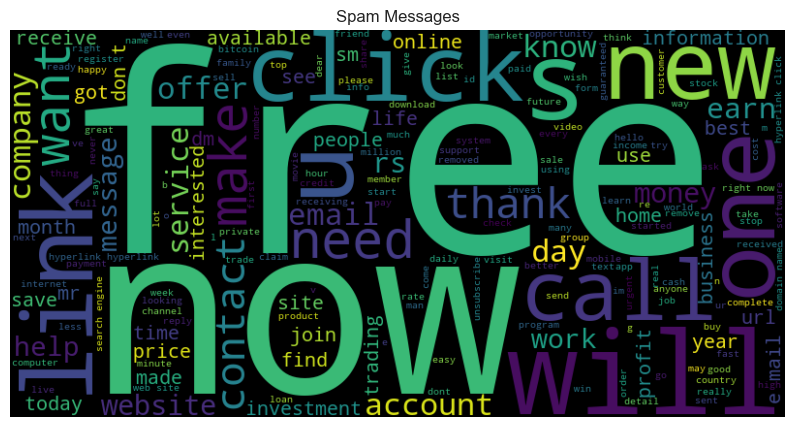

In [37]:
spam_df = df[df['spam'] == 1]
spam_text = ' '.join(spam_df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(spam_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Messages')
plt.show()

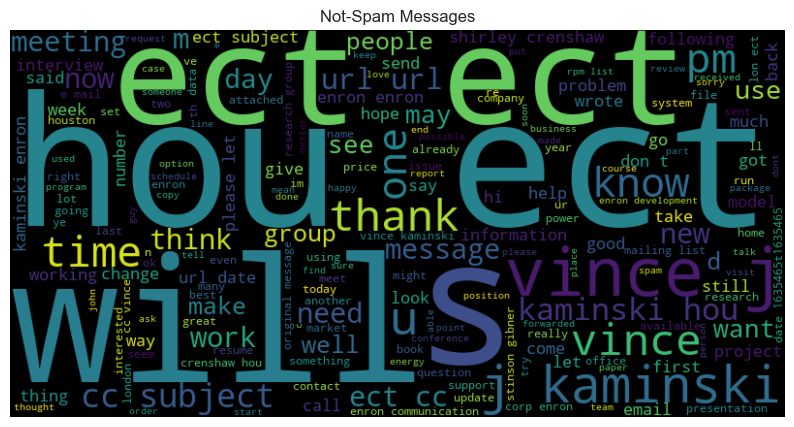

In [39]:
spam_df = df[df['spam'] == 0]
spam_text = ' '.join(spam_df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(spam_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Not-Spam Messages')
plt.show()

Разделим размеченные данные на трейн и тест выборки, проконтролируем количество объектов в каждой

In [18]:
X , y = df['text'] ,df['spam']

In [19]:
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size=0.2,random_state=42)
print(len(X_train))
print(len(X_test))

13013
3254


Векторизируем фичи; исключим служебные части речи для достоверного отображения признаков естественного языка моделью

In [50]:
vectorizer = TfidfVectorizer(stop_words="english",max_df=0.7)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Обучение моделей

Обучим несколько моделей классификаторов, подходящих для данных небольшой размерности. Проанализируем полученные метрики, визуализируем перфоманс моделей на графике распределения значений. По ключевой метрики ROC-AUC score выберем наиболее эффективную модель для скоринга.

 
## SVM
В первую очередь, используем метод опорных векторов (SVM) для задач классификации с линейным ядром (имплементируем стандартный класс sklearn - LinearSVC). Так как финальная задача сводится к простому скорингу без проверки вероятностей, данная модель является быстрым и оптимальным решением. 

In [23]:
clf = LinearSVC()
clf.fit(X_train_vectorized,y_train)

y_pred = clf.predict(X_test_vectorized)
print("accuracy Score: ", accuracy_score(y_test, y_pred))
print()
print("confusion matrix: ")
print(confusion_matrix(y_test, y_pred))
print()
print("precision score: ", precision_score(y_test, y_pred))
roc_auc_svc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc_svc)

accuracy Score:  0.9468346650276582

confusion matrix: 
[[2202   69]
 [ 104  879]]

precision score:  0.9272151898734177
ROC-AUC Score: 0.931909166531162


/Users/nikitarodionov/PycharmProjects/pythonProject4/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Text(0.5, 1.0, 'SVC Performance')

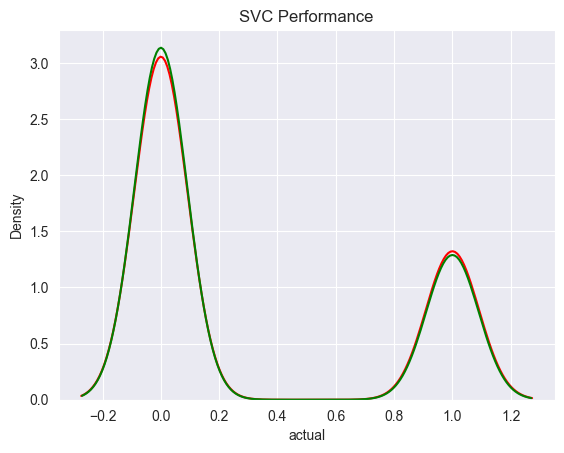

In [24]:
data_frame_svc = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
ax = sns.kdeplot(data_frame_svc['actual'], color='r', label='Actual Price')
sns.kdeplot(data_frame_svc['predicted'], color='g', label='Predicted Price', ax=ax)
plt.title("SVC Performance")

## Случайный лес
В качестве альтернативного метода используем классификатор на основе случайного леса (стандартный класс sklearn - RandomForestClassifier). В теории этот алгоритм должен немного уступать линейным опорным векторам в работе с текстом. Число решающих деревьев было подобрано в ходе экспериментов с гиперпараметрами.

In [36]:
rfc = RandomForestClassifier(n_estimators=500, random_state=2)
rfc.fit(X_train_vectorized,y_train)

y_pred_rfc = rfc.predict(X_test_vectorized)
print("accuracy Score: ", accuracy_score(y_test, y_pred_rfc))
print()
print("confusion matrix: ")
print(confusion_matrix(y_test, y_pred_rfc))
print()
print("precision score: ", precision_score(y_test, y_pred_rfc))
roc_auc_rfc = roc_auc_score(y_test, y_pred_rfc)
print("ROC-AUC Score:", roc_auc_rfc)

accuracy Score:  0.9326982175783651

confusion matrix: 
[[2254   17]
 [ 202  781]]

precision score:  0.9786967418546366
ROC-AUC Score: 0.8935104616436264


Text(0.5, 1.0, 'RFC Performance')

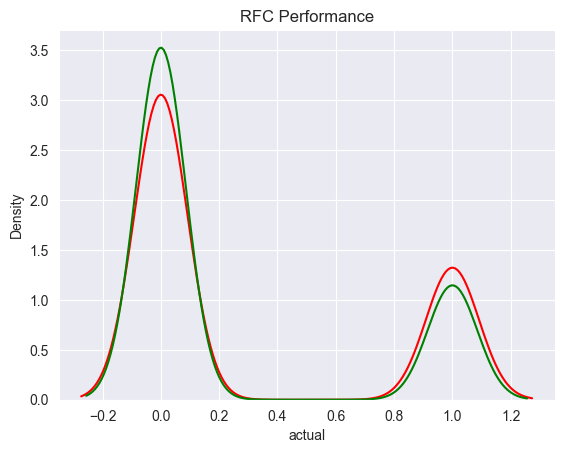

In [43]:
data_frame_rfc = pd.DataFrame({'actual': y_test, 'predicted': y_pred_rfc})
ax = sns.kdeplot(data_frame_rfc['actual'], color='r', label='Actual Price')
sns.kdeplot(data_frame_rfc['predicted'], color='g', label='Predicted Price', ax=ax)
plt.title("RFC Performance")

## Градиентный бустинг

В финале обучим градинетный бустинг, обладающий большей точностью в сравнении со случайным лесом. Была использована реализация алгоритма на опенсорсном фреймворке с хорошей скоростью и производительностью XGBoost. 

In [42]:
xgb = XGBClassifier(n_estimators=650,random_state=2)
xgb.fit(X_train_vectorized,y_train)

y_pred_xgb = xgb.predict(X_test_vectorized)
print("accuracy Score: ", accuracy_score(y_test, y_pred_xgb))
print()
print("confusion matrix: ")
print(confusion_matrix(y_test, y_pred_xgb))
print()
print("precision score: ", precision_score(y_test, y_pred_xgb))
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print("ROC-AUC Score:", roc_auc_xgb)

accuracy Score:  0.9354640442532268

confusion matrix: 
[[2217   54]
 [ 156  827]]

precision score:  0.9387060158910329
ROC-AUC Score: 0.9087620324915909


Text(0.5, 1.0, 'XGB Performance')

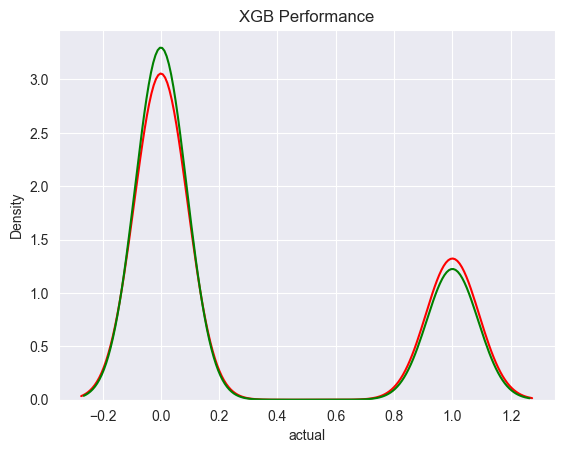

In [44]:
data_frame_xgb = pd.DataFrame({'actual': y_test, 'predicted': y_pred_xgb})
ax = sns.kdeplot(data_frame_xgb['actual'], color='r', label='Actual Price')
sns.kdeplot(data_frame_xgb['predicted'], color='g', label='Predicted Price', ax=ax)
plt.title("XGB Performance")

## Выводы
По итогам всех экспериментов лучшую ключевую метрику показала модель на опорных векторах (ROC-AUC score = 0.931). Градиентный бустинг уступил по ключевой метрике (ROC-AUC score = 0.908), но показал большую accuracy = 0.935 (в сравнении с 0.932). Используем модель на опорных векторах для скоринга данных. 

# Скоринг тестовых данных

Загрузим датасет, преобразуем в pd.DataFrame, векторизуем признаки, затем создадим вектор предсказаний с помощью LinearSVC (преобразуем численные значения обратно в литеральные "spam" и "ham"). В конце объединим данные в csv таблицу.

In [46]:
df_scoring = pd.read_csv('test_spam.csv')
df_scoring.shape

(4070, 1)

In [55]:
X_scoring = df_scoring['text']
X_scoring_vectorized = vectorizer.transform(X_scoring)
y_scored_clf = clf.predict(X_scoring_vectorized)

In [58]:
y_scored_lit = np.array(["ham" if label == 0 else "spam" for label in y_scored_clf])
y_scored_lit

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [59]:
import csv

data = list(zip(y_scored_lit, X_scoring))

csv_file = "scored_spam.csv"
with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['score', 'text'])
    writer.writerows(data)